# 0.0 IMPORTAÇÃO 

In [1]:
import pandas as pd
import numpy as np
import inflection
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime as dt
import xgboost as xgb
import random
import warnings 
import pickle

from boruta                 import BorutaPy
from scipy                  import stats as ss
from IPython.display        import Image
from matplotlib             import rcParams
from matplotlib.gridspec    import GridSpec
from sklearn.preprocessing  import MinMaxScaler, RobustScaler, LabelEncoder 
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression
from sklearn.linear_model   import Lasso



## 0.1 Funções de Ajudas

In [2]:
warnings.filterwarnings("ignore")

In [3]:
rs = RobustScaler()
mms = MinMaxScaler()

In [4]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corrigido = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)*(r-1)/(n-1)
    rcorr = r - (k-1)*(r-1)/(n-1)
    return np.sqrt((chi2/n) / (min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/ y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(model_name, model, k, X_train, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, k)):
        if verbose:
            print(f'Kfold number: {k}')
        x_training = X_train[cols_selected_boruta_full]
        validate_start_date = x_training['date'].max() - dt.timedelta(days=k*6*7)
        validate_end_date = x_training['date'].max() - dt.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validate_start_date]
        validation = x_training[(x_training['date'] >= validate_end_date) & (validate_start_date <= validate_end_date)]

        # training and validate dataset

        x_training = training.drop(['date', 'sales'], axis=1)
        y_training = training['sales']

        x_validation = validation.drop(['date', 'sales'], axis=1)
        y_validation = validation['sales']
        #model

        m = model.fit(x_training, y_training)

        #prediction
        yhat = m.predict(x_validation)

        #performance
        result = ml_error(model_name, np.expm1(y_validation), np.expm1(yhat))
        if verbose:
            print(result)
        mae_list.append(result['MAE']) 
        mape_list.append(result['MAPE']) 
        rmse_list.append(result['RMSE']) 

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE': np.round(np.mean(mape_list), 2).astype(str)+ ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])




## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Renomear Colunas

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão do DataSet

In [10]:
print(f'Numeros de Linhas: {df1.shape[0]}')
print(f'Numeros de Colunas: {df1.shape[1]}')

Numeros de Linhas: 1017209
Numeros de Colunas: 18


## 1.3 Tipos de Dados

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Checagem de N.A

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Tratando os N.A

In [14]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dez'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = np.int64(df1['competition_open_since_month'])
df1['competition_open_since_year'] = np.int64(df1['competition_open_since_year'])

df1['promo2_since_week'] = np.int64(df1['promo2_since_week'])
df1['promo2_since_year'] = np.int64(df1['promo2_since_year'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Estatística Descritiva 

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attibutes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64'])

### 1.7.1 Variáveis Numéricas 

In [19]:
# Tendencia Central - Media e Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Despesão - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Variáveis Categóricas

In [20]:
cat_attibutes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

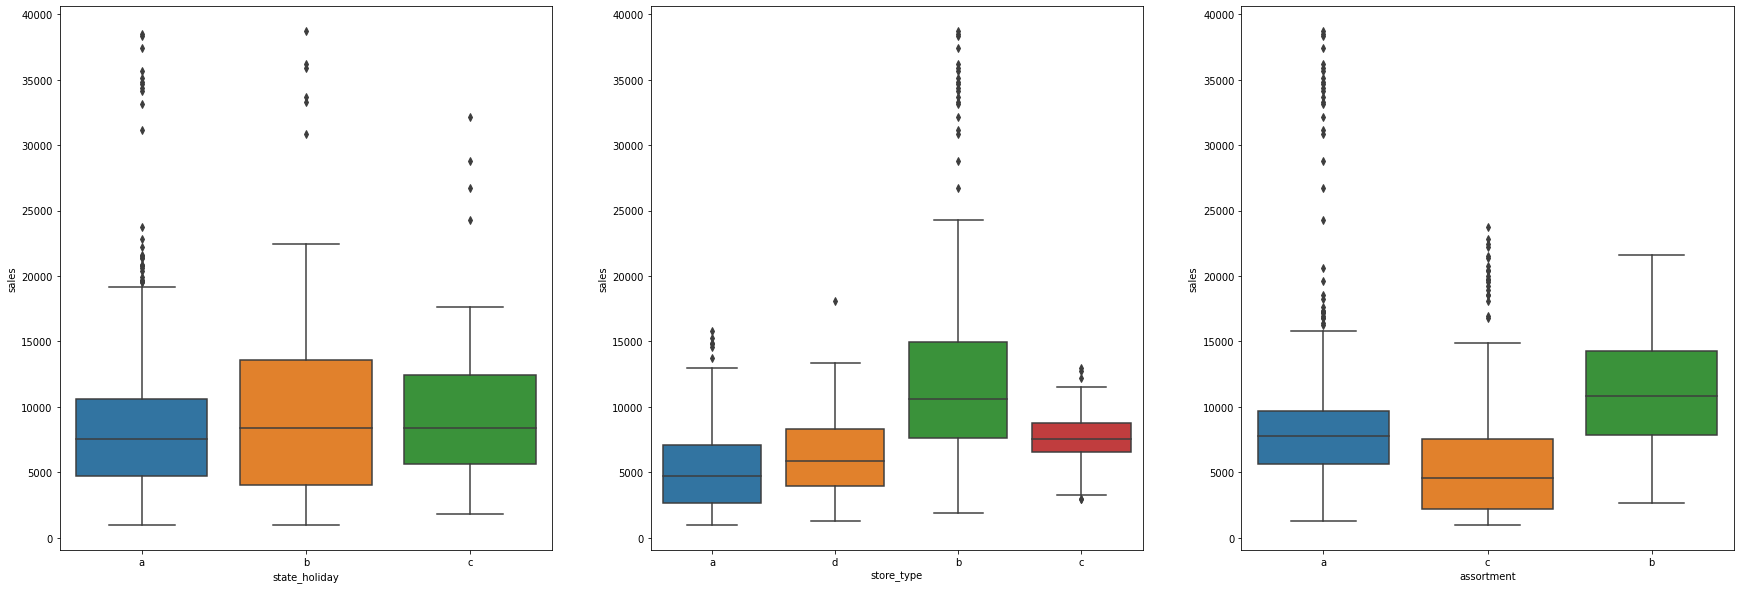

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplots(figsize=(30,10))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

## 2.1 Criação de Hipótesis

In [22]:
df2 = df1.copy()

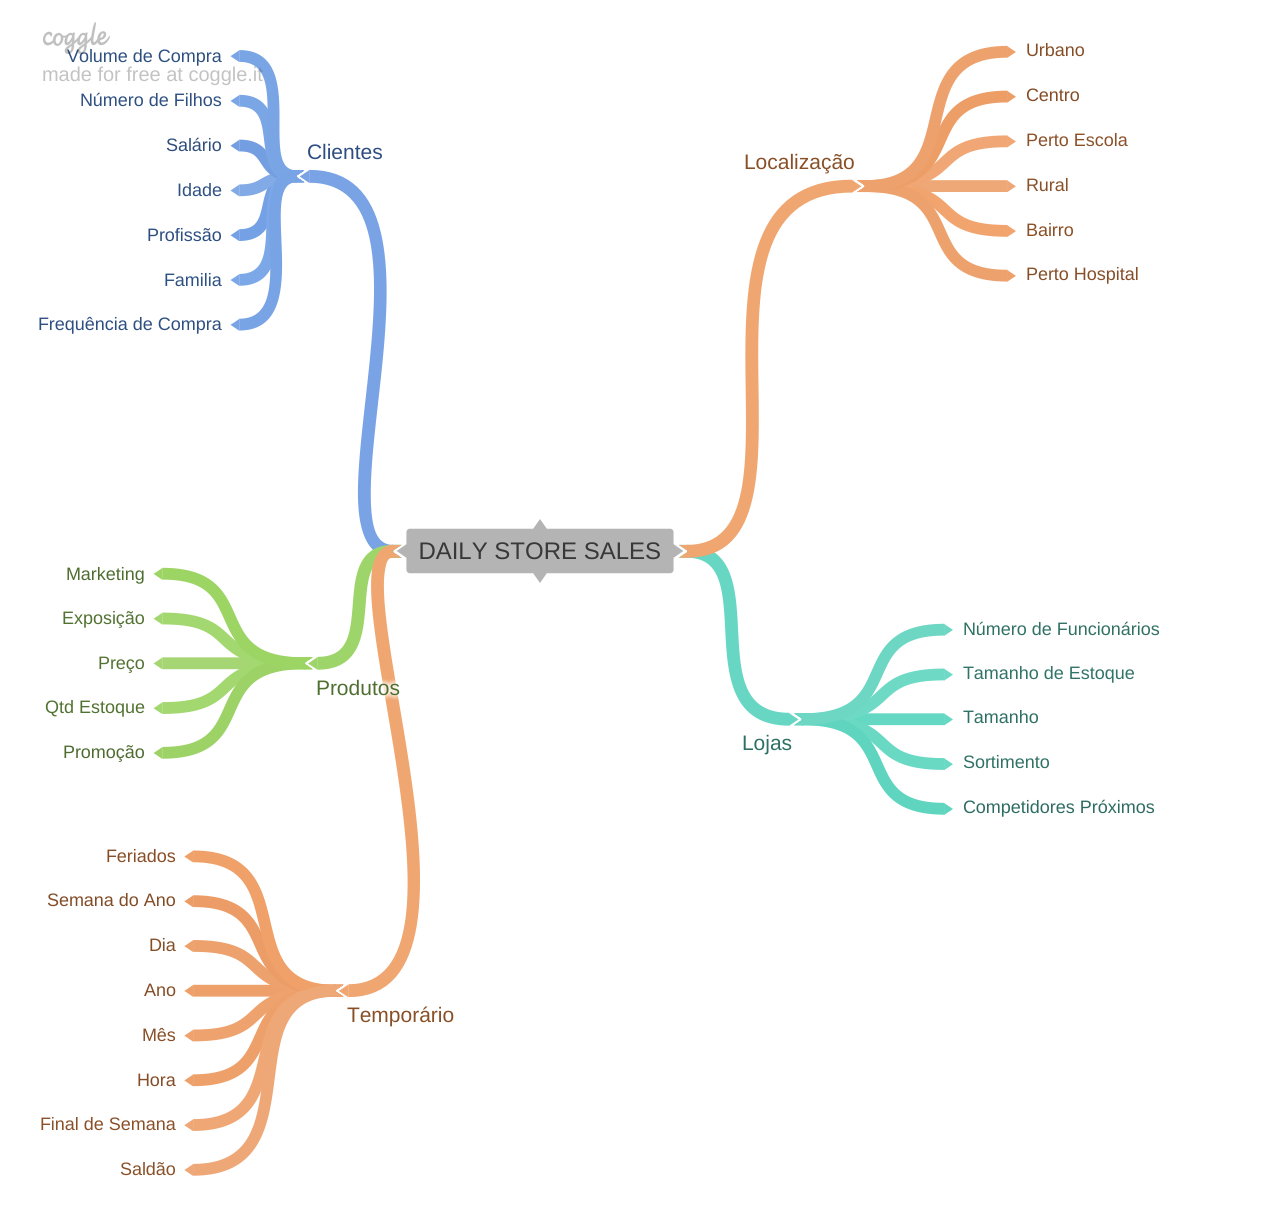

In [23]:
Image('img/mindmap_hypotesis.png')

### 2.1.1 Criação de Hipoteses Loja

~> 1 Lojas com maior quadro de funcionários, deveriam vender mais. 

~> 2 Lojas com maior estoque, deveriam vender mais .

~> 3 Lojas com maior porte, deveriam vender mais.

~> 4 Lojas com menor porte, deveriam vender menos.

~> 5 Lojas com maior sortimentos, deveriam vender mais.

### 2.1.2 Criação de Hipoteses Produtos



~> 1 Lojas que investem em Marketing, deveriam vender mais. 

~> 2 Lojas que expoe mais os produtos na vitrine, deveriam vender mais.

~> 3 Lojas que tem preços menores, deveriam vender mais. 

~> 4 Lojas que tem preços menores por mais tempo nos produtos, deveriam vender mais.


### 2.1.3 Criação de Hipoteses Tempo



~> 1 Lojas que tem mais feriados deveriam, vender menos

~> 2 Lojas que abrem nos primeiros 6 meses do ano deveriam vender mais.

~> 3 Lojas que abrem nos finais de semana, deveriam vender mais.


## 2.2 Lista Final de Hipóteses

## 2.3 Feature Engineering

In [24]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2 ['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# Competition Since
df2['competition_since'] = df2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(x + '-1', '%Y-%W-%w') - dt.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(int)

# Assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else  'christmas' if x == 'c' else 'regular_day')


In [95]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [26]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem de Colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

1 - Ganhar experiência de negócio

2 - Validar hipóteses de Negócio (Insights)

3 - Perceber variáveis que são importantes para o Modelo.

In [29]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

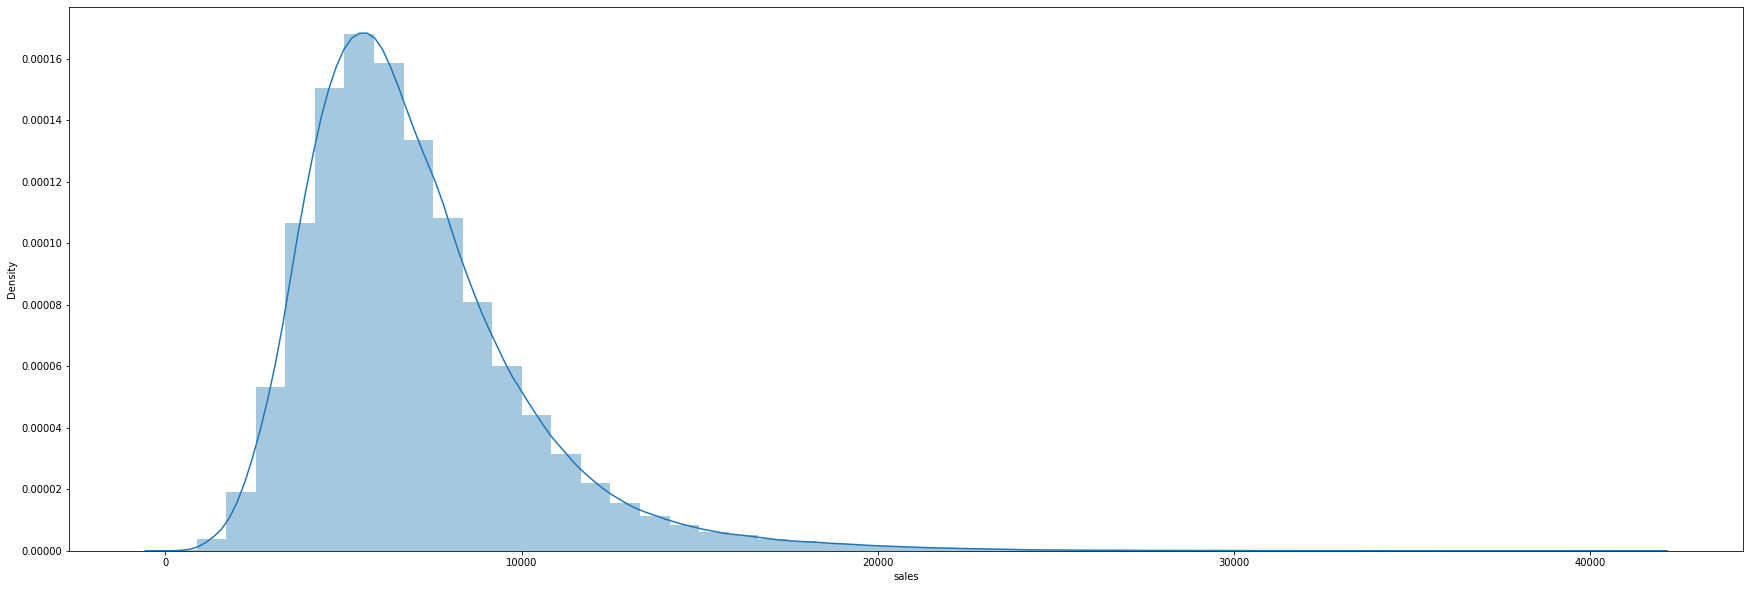

In [30]:
plt.figure(figsize = (30,10))
sns.distplot(df4['sales']);

### 4.1.2 Numérical Variable

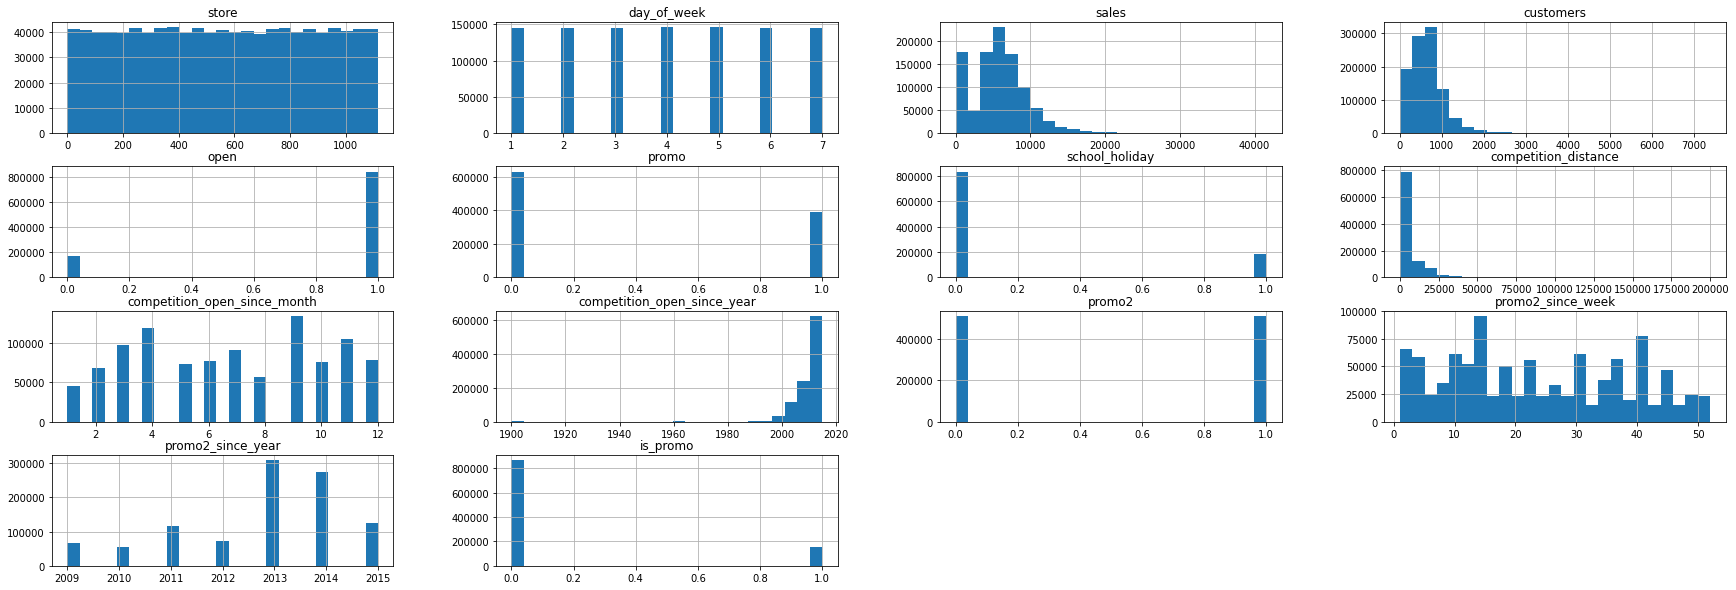

In [31]:
num_attributes.hist(bins=25, figsize = (30,10));

### 4.1.3 Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

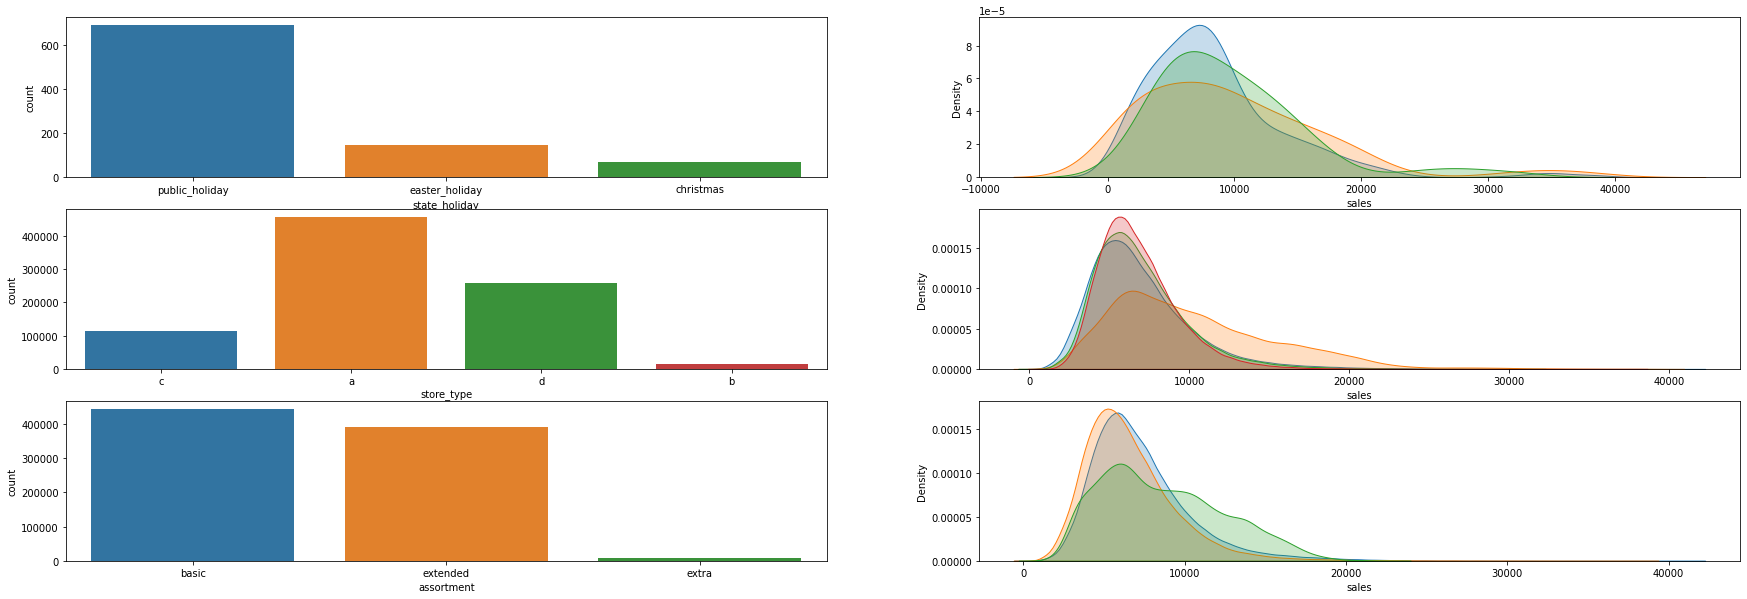

In [32]:
a = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize = (30,10))
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade = True)

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade = True)

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade = True)


## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maiores sortimento, vendem menos.

<AxesSubplot:xlabel='year_week'>

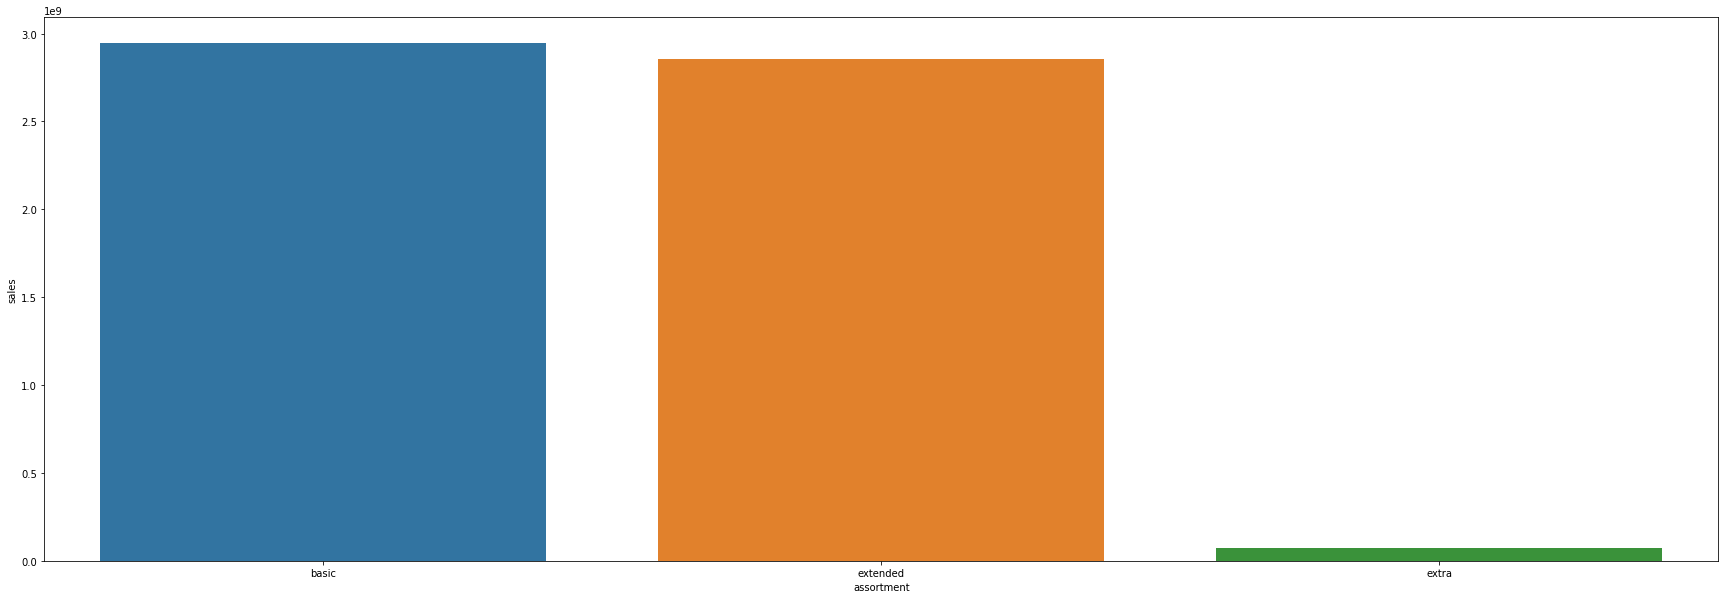

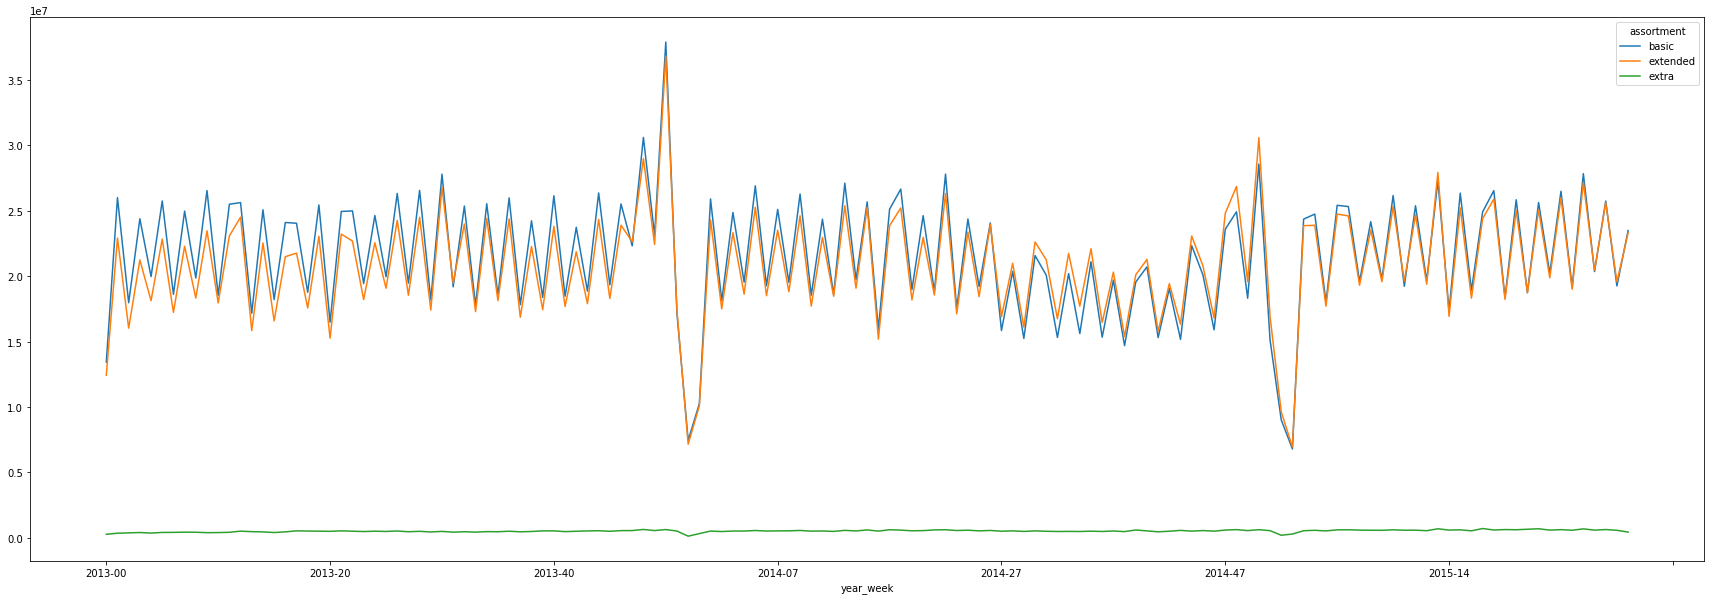

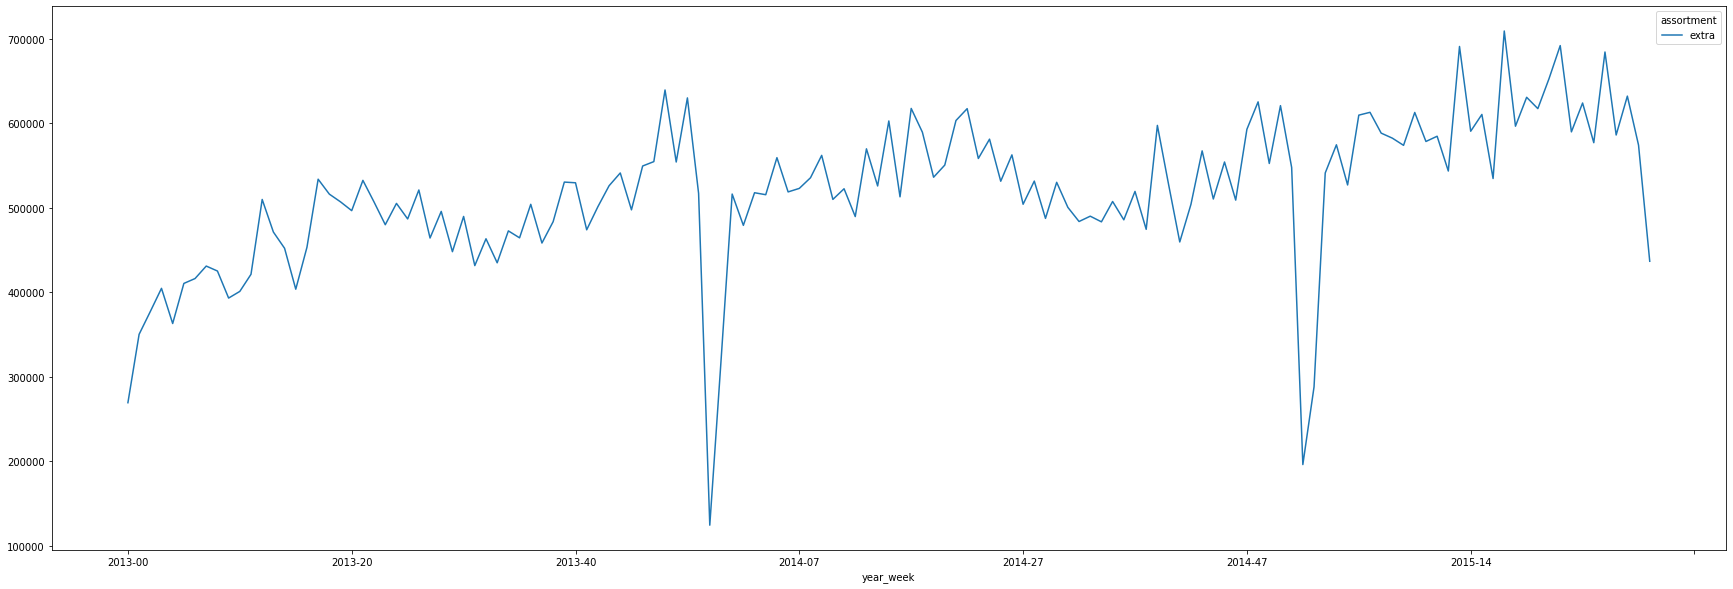

In [33]:
plt.figure(figsize = (30,10))

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week' , columns='assortment' ,values='sales').plot(figsize = (30,10))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week' , columns='assortment' ,values='sales').plot(figsize = (30,10))

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos, vendem mais.

<AxesSubplot:>

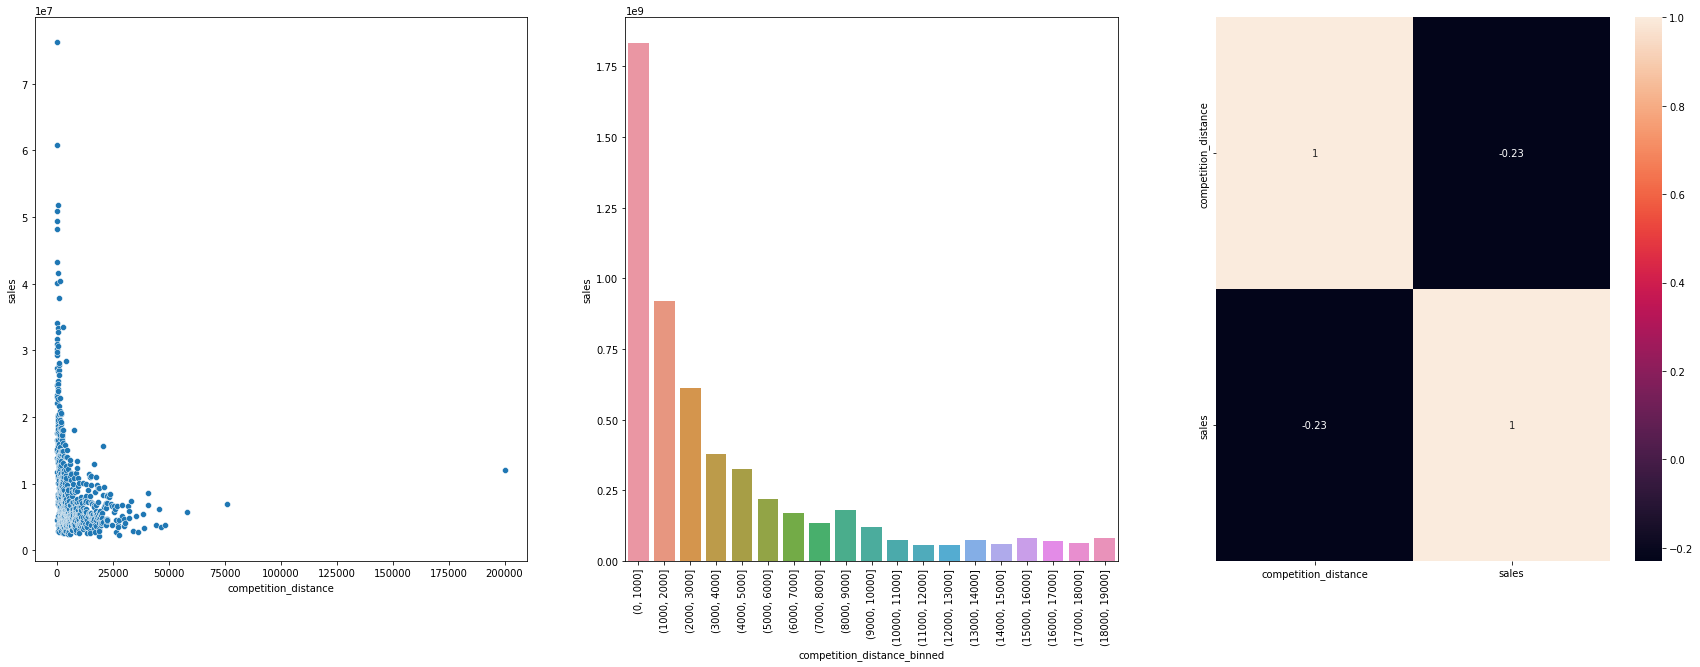

In [34]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize = (30,10))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation=90)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H3. Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com competidores com mais tempo, vendem menos.

<AxesSubplot:>

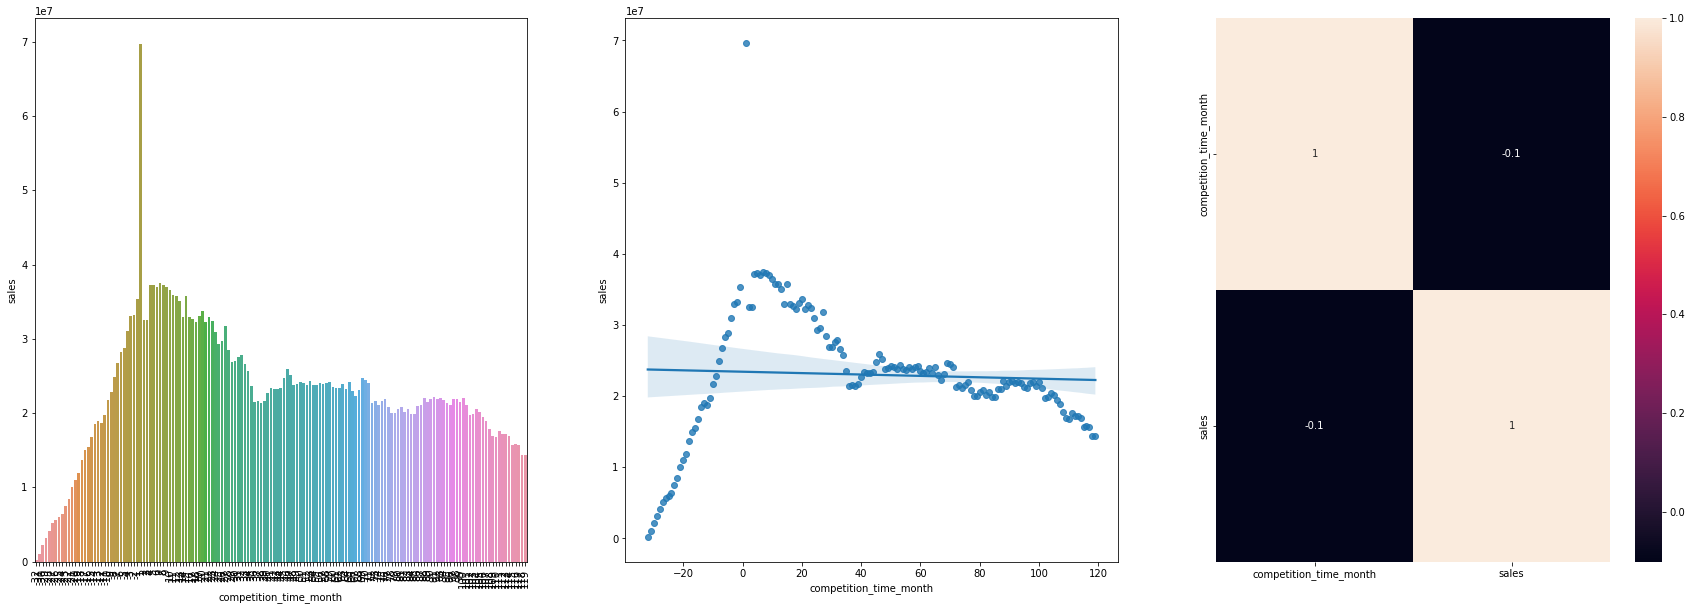

In [35]:

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.figure(figsize = (30, 10))
plt.subplot(1,3,1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month', y='sales', data=aux2 )

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### H4. Lojas com promoção ativas por mais tempo, deveriam vender mais. 
**FALSA** Loja com promoções ativas por mais tempo, vendem menos.

In [36]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


<AxesSubplot:>

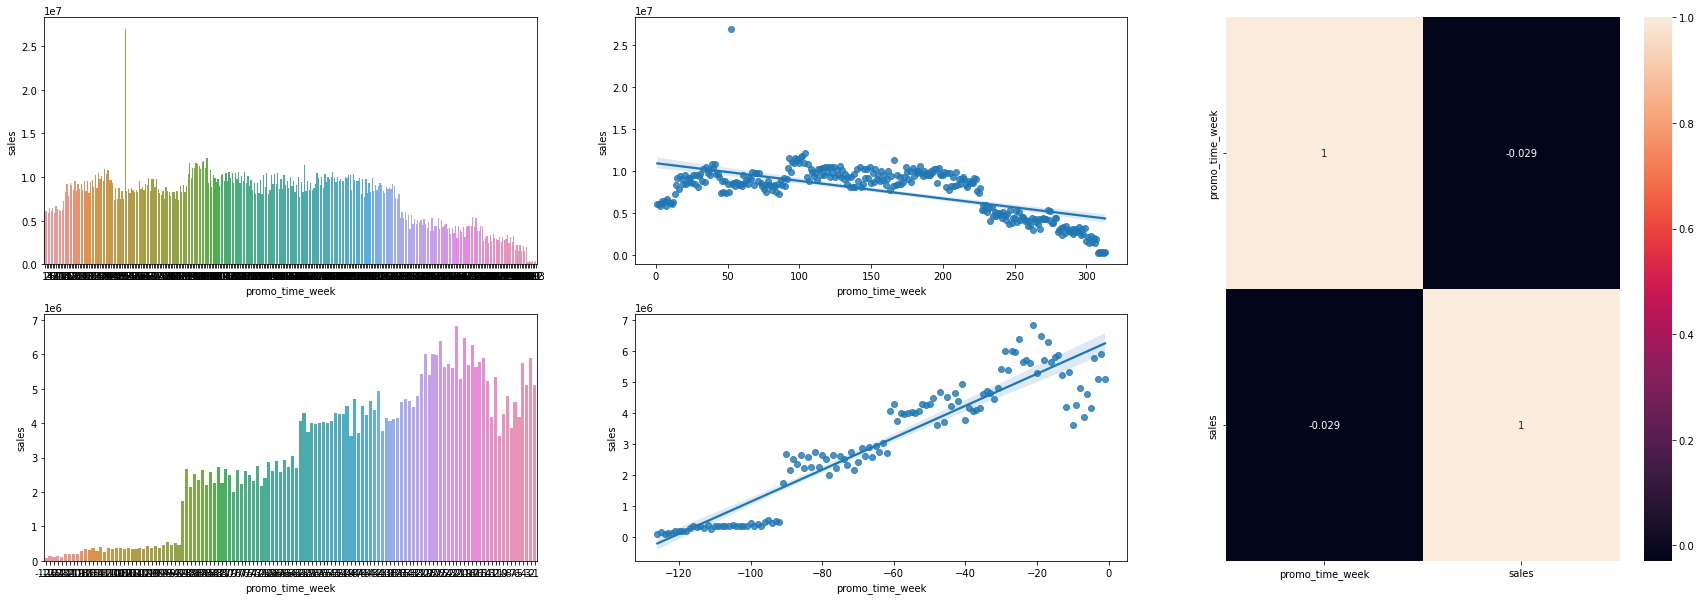

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize=(30,10))

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)



plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)


plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H5. Lojas com promoção consecutivas por mais tempo, deveriam vender mais. 
**FALSA** Lojas com promoções consecutivas vendem menos.

In [38]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


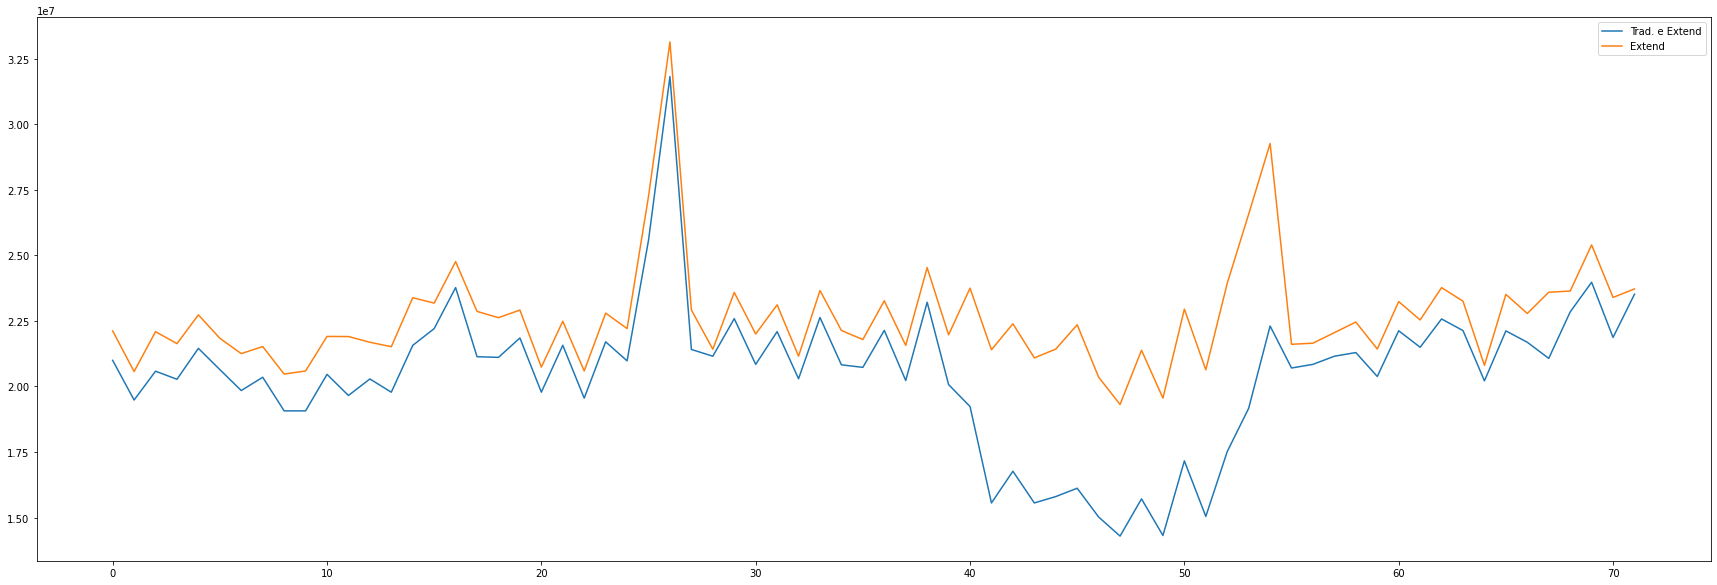

In [39]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize = (30,10))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax, figsize = (30,10))

ax.legend(labels = ['Trad. e Extend', 'Extend'])

### H6. Lojas que abrem no natal deveriam vender mais. 
**FALSA** Lojas que abrem no natal, vendem menos. 

<AxesSubplot:xlabel='year', ylabel='sales'>

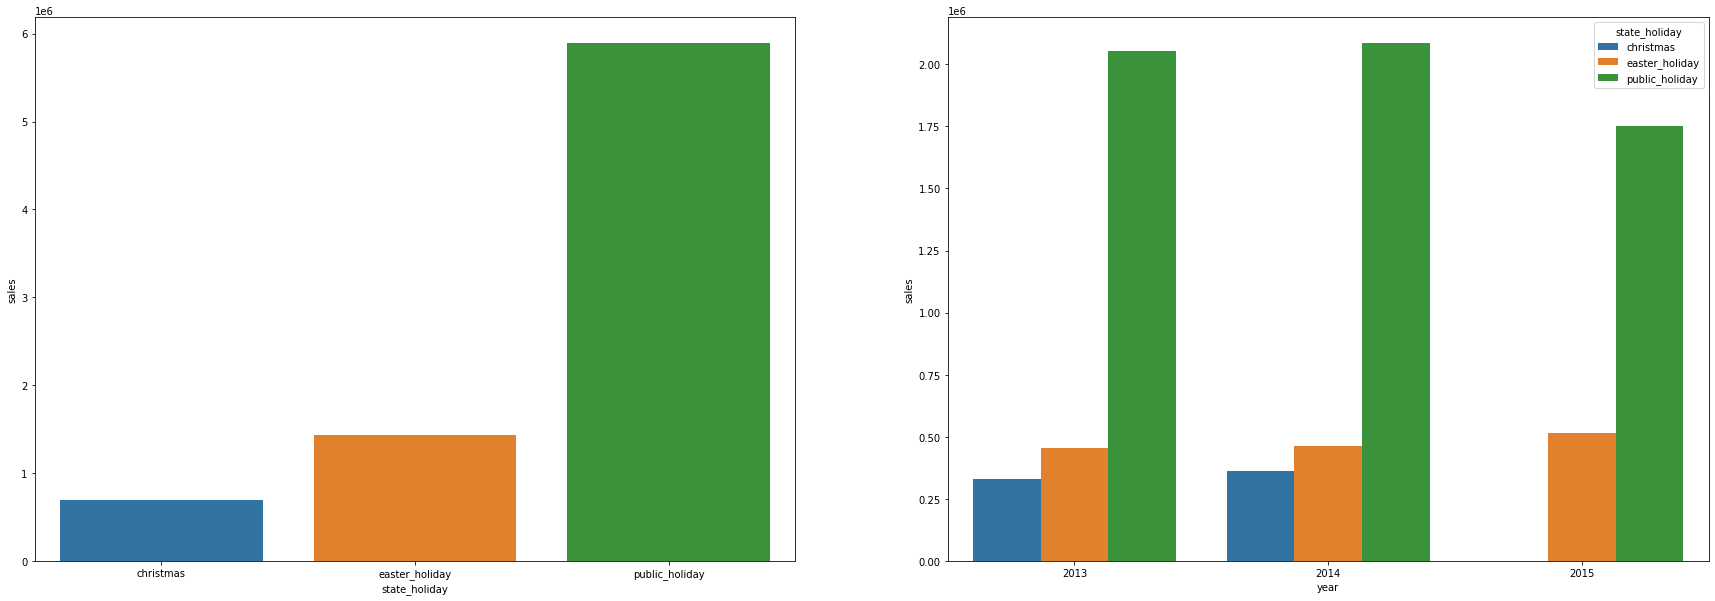

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize = (30,10))
plt.subplot(1,2,1)
sns.barplot(x = 'state_holiday', y = 'sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['state_holiday', 'sales', 'year']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### H7. Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos.

<AxesSubplot:>

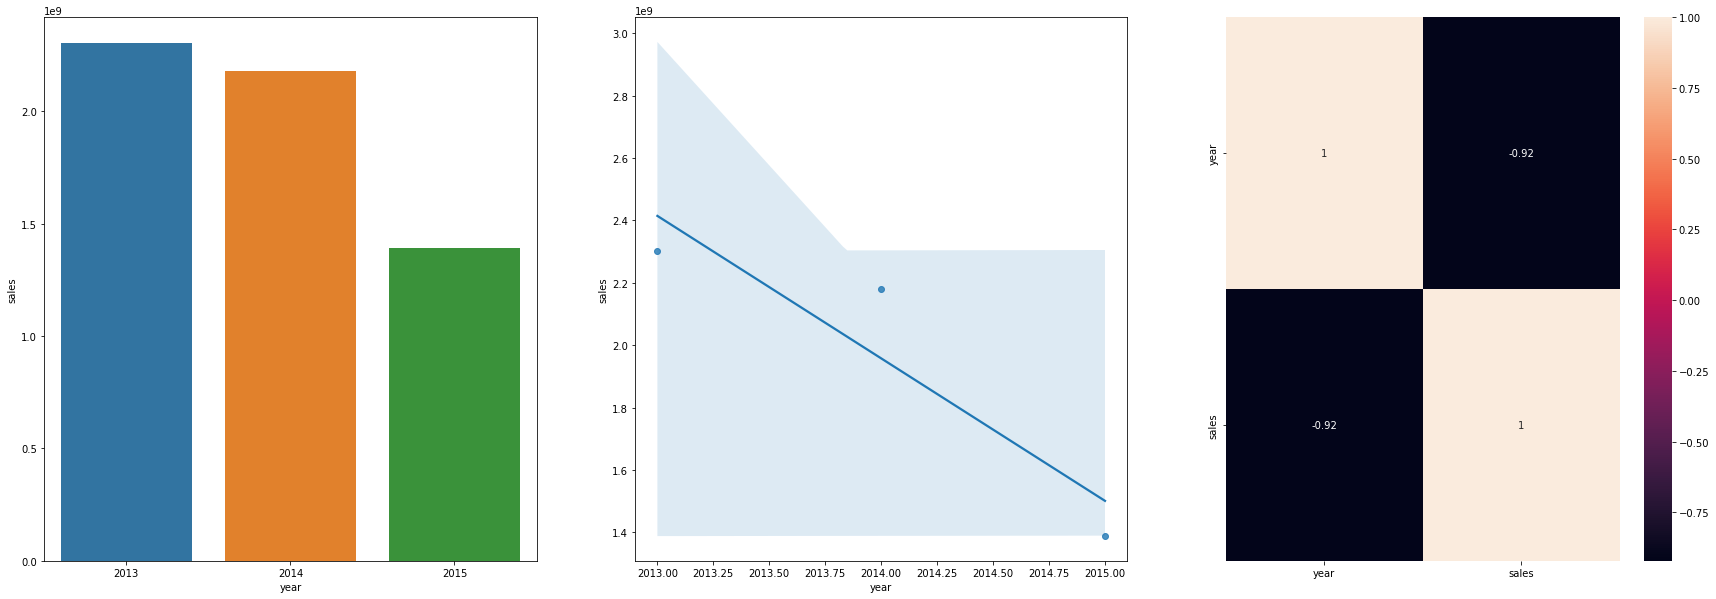

In [41]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(30,10))

grid = GridSpec(1,3)
plt.subplot(grid[0,0])
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(grid[0,1])
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(grid[0,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)



### H8 Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano. 

<AxesSubplot:>

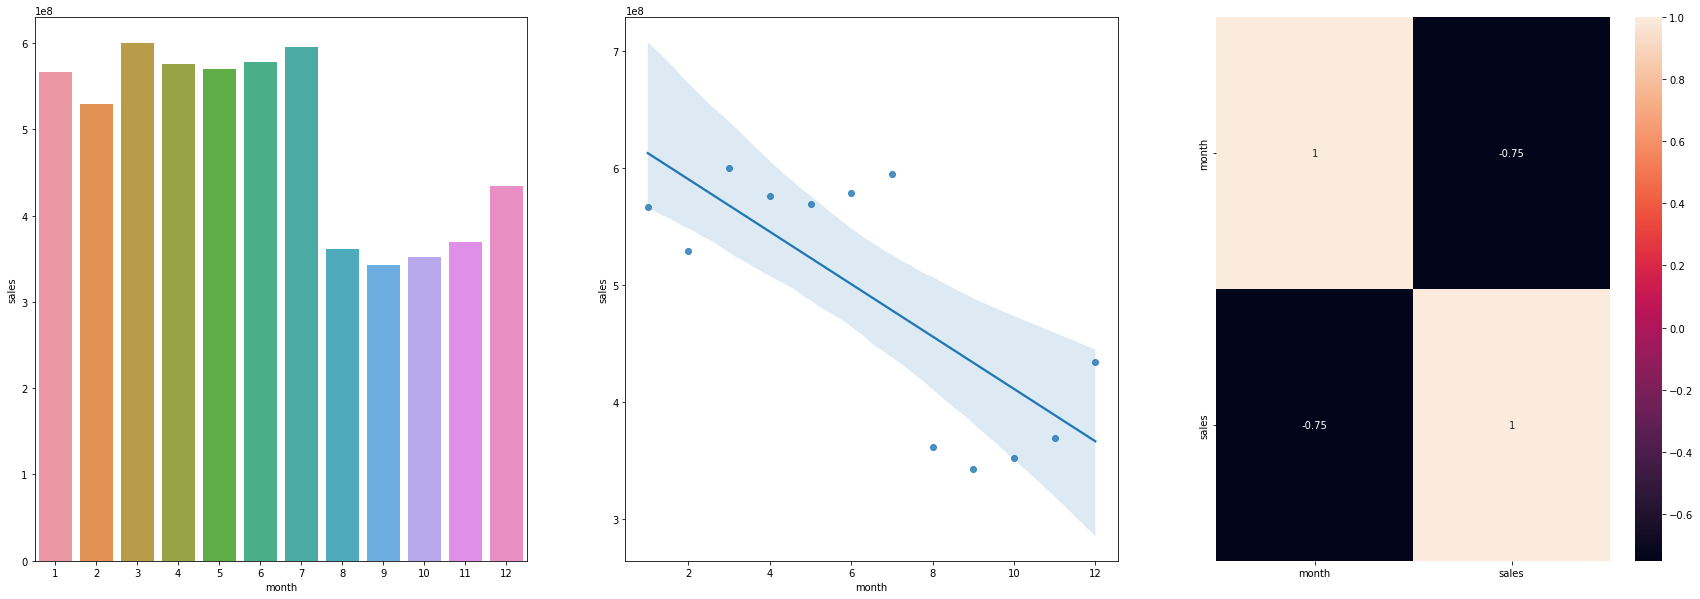

In [42]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(30,10))

grid = GridSpec(1,3)
plt.subplot(grid[0,0])
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(grid[0,1])
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(grid[0,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H9 Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** As lojas vendem sim mais depois do dia 10 de cada mês. 

<AxesSubplot:xlabel='before_after', ylabel='sales'>

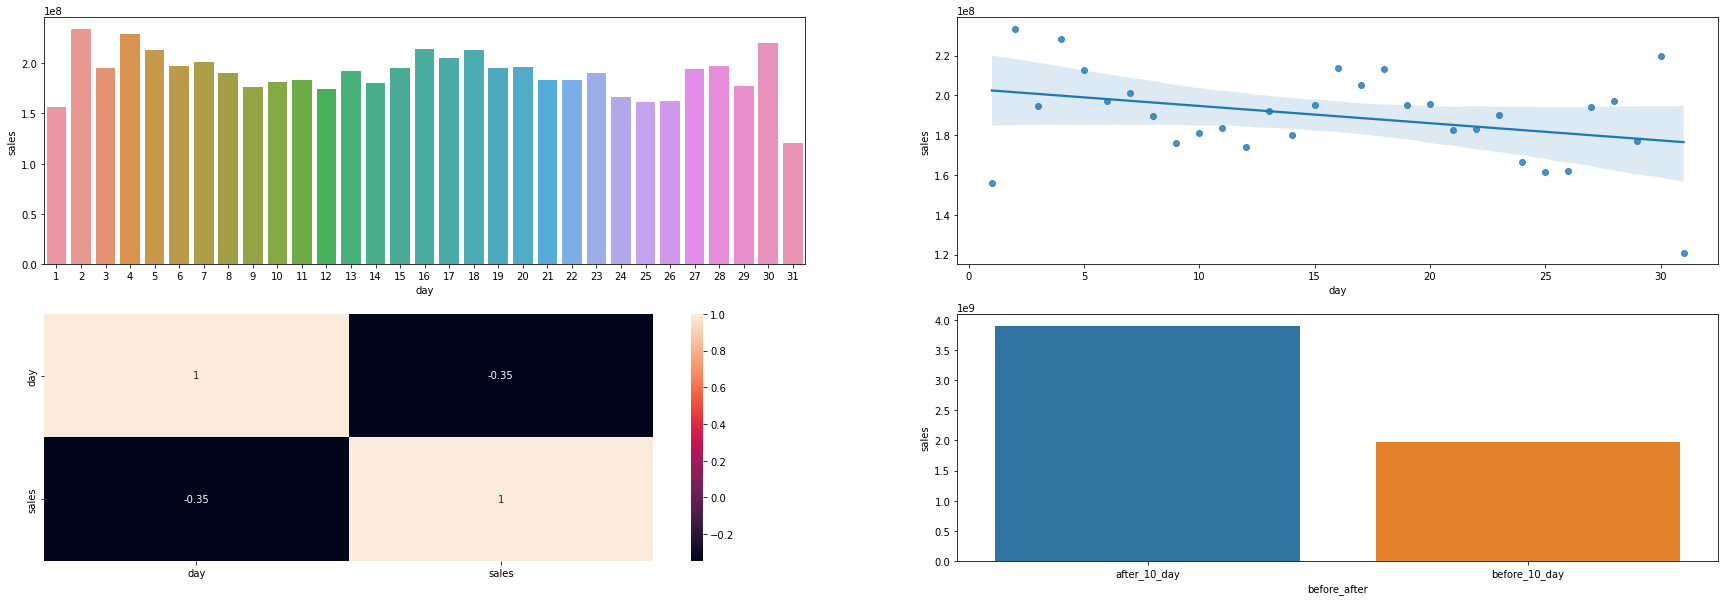

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(30,10))

grid = GridSpec(2,2)
plt.subplot(grid[0,0])
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(grid[0,1])
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(grid[1,0])
sns.heatmap(aux1.corr(method='pearson'), annot=True)


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(grid[1,1])
sns.barplot(x='before_after', y = 'sales', data=aux2)

### H10 Lojas deveriam vender menos nos fins de semana.
**VERDADEIRO** Lojas vendem menos nos fins de semana.

<AxesSubplot:xlabel='is_weekend', ylabel='sales'>

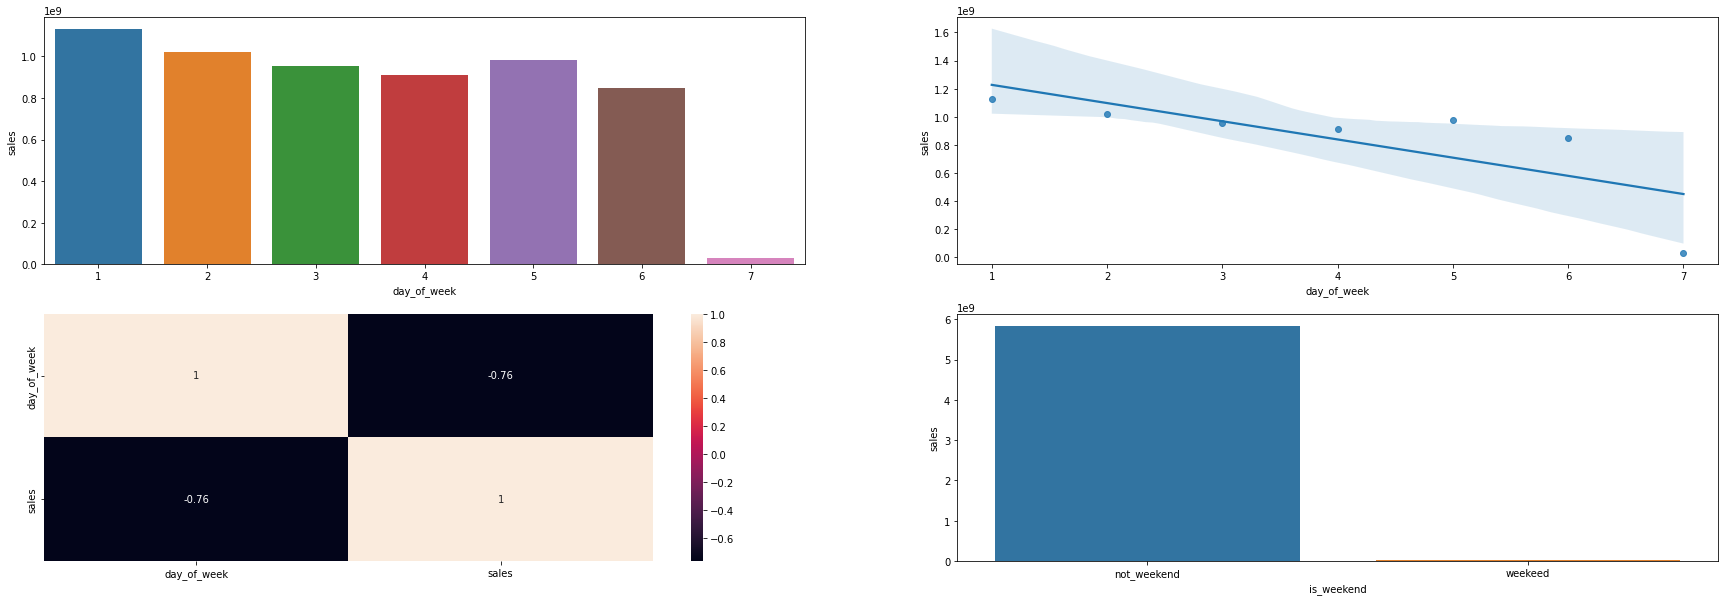

In [44]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(30,10))

grid = GridSpec(2,2)
plt.subplot(grid[0,0])
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(grid[0,1])
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(grid[1,0])
sns.heatmap(aux1.corr(method='pearson'), annot=True)


aux1['is_weekend'] = aux1['day_of_week'].apply(lambda x: 'weekeed' if (x == 6 | x ==7 ) else 'not_weekend')
aux2 = aux1[['is_weekend', 'sales']].groupby('is_weekend').sum().reset_index()
plt.subplot(grid[1,1])
sns.barplot(x='is_weekend', y = 'sales', data=aux2)

### H11 Lojas deveriam vender menos em feriados escolares
**PARCIALMENTE VERDADEIRA** Lojas vendem menos durante feriados escolares, exceto no mês de agosto, que é mes de férias escolares.

<AxesSubplot:xlabel='month', ylabel='sales'>

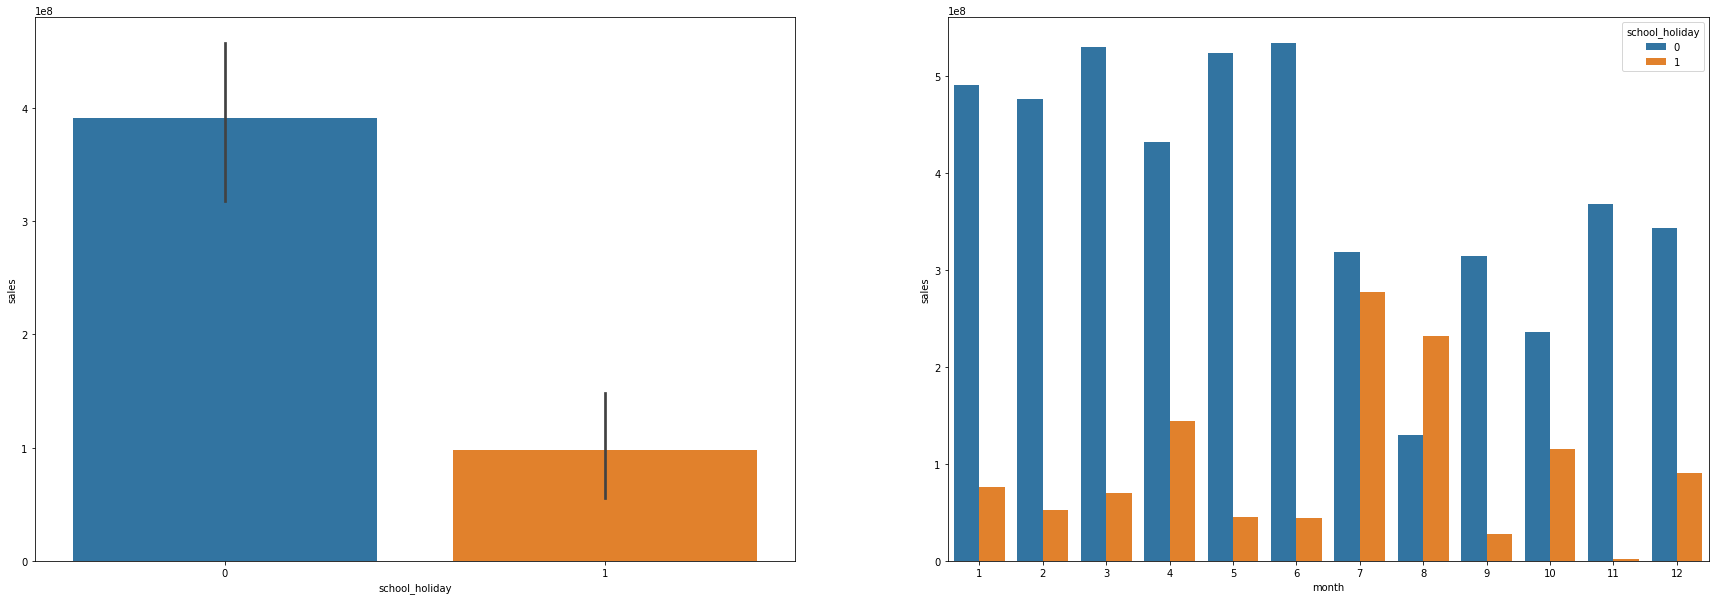

In [45]:
aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.barplot(x='school_holiday', y = 'sales', data = aux1)
plt.subplot(1,2,2)
sns.barplot(x='month', hue='school_holiday', y = 'sales', data = aux1)

In [46]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.3 Análise Multivariada

### 4.3.1 Atributos Numéricos

<AxesSubplot:>

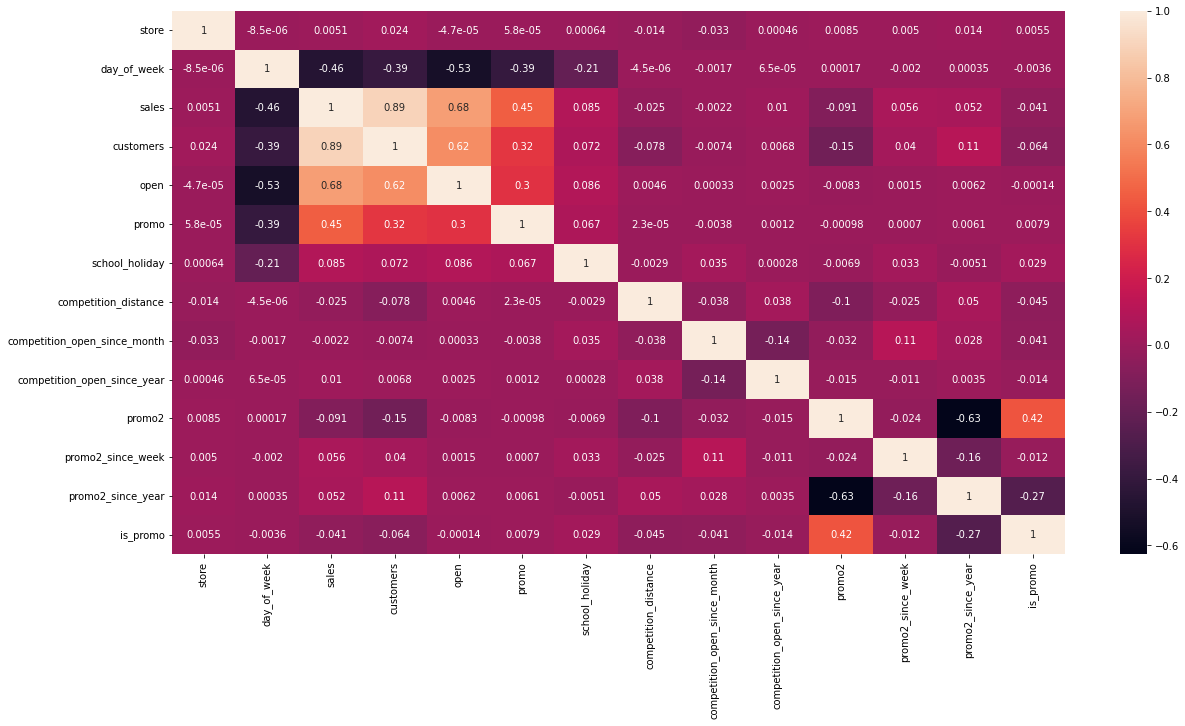

In [47]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize = (20,10))
sns.heatmap(correlation, annot=True)

### 4.3.2 Atributos Categóricos

<AxesSubplot:>

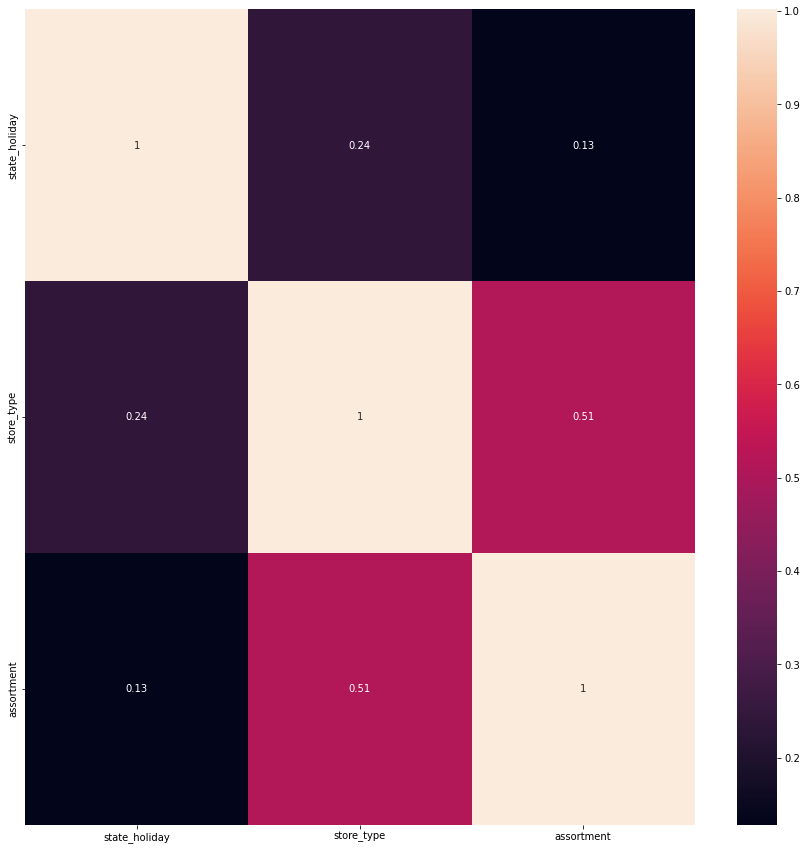

In [48]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])
a4 = cramer_v(a['store_type'], a['state_holiday'])  
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])
a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]       
              })

d = d.set_index(d.columns)
plt.figure(figsize=(15,15))
sns.heatmap(d, annot = True)



# 5.0 PREPARAÇÃO DOS DADOS 

In [49]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [50]:
# Robust Scaler 

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl', 'wb'))

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameters/competition_time_month_scaler.pkl', 'wb'))

# MinMaxScaler 

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameters/promo_time_week_scaler.pkl', 'wb'))

df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameters/year_scaler.pkl', 'wb'))


## 5.3 Transformação

### 5.3.1 Encoding

In [51]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Transformação da Variável Resposta

<AxesSubplot:xlabel='sales', ylabel='Density'>

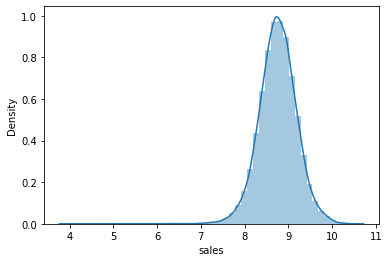

In [52]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

# week
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

# 6.0 SELEÇÃO DE VARIÁVEIS

In [54]:
df6 = df5.copy()

## 6.1 Split DataFrame into training and test dataset

In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [56]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - dt.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [57]:
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']


X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

### 6.1.1 Boruta as Feature Selector

In [58]:
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()

#rf = RandomForestRegressor(n_jobs=1)

#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.1.2 Melhores Features selecionadas pelo Boruta

In [59]:
#cols_selected = boruta.support_.tolist()
#
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

### 6.1.3 Melhores Features selecionadas pelo Boruta

In [60]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING

In [61]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [62]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [63]:
#lr = LinearRegression().fit(x_train, Y_train)

#yhat_lr = lr.predict(x_test)
#lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
#lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [64]:
#lr = LinearRegression()
#lr_cv = cross_validation('Linear Regretion', model = lr, k = 6, X_train = X_train, verbose = True)
#lr_cv 

## 7.3 Linear Regression Regularized Model - Lasso

In [65]:
#lrr = Lasso(alpha = 0.01).fit(x_train, Y_train)

#yhat_lr = lr.predict(x_test)
#lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lr))
#lrr_result

### 7.3.1 Linear Regression Model - Cross Validation

In [66]:
#llr = Lasso(alpha = 0.001)
#llr_cv = cross_validation('Lasso Regretion', model = llr, k = 6, X_train = X_train, verbose = True)
#llr_cv

## 7.4 Random Forest Regressor

In [67]:
#rf = RandomForestRegressor(n_estimators = 100, random_state = 42).fit(x_train, Y_train)

#yhat_rf = rf.predict(x_test)

#rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [68]:
#rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

#rf_cv = cross_validation('Random Forest Regressor', model = rf, k = 6, X_train = X_train, verbose = True)

## 7.5 XGBoost Regressor

In [69]:
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                             n_estimators = 1000,
#                             eta = 0.01,
#                             max_depth = 10,
#                             subsample = 0.7,
#                             colsample_bytree=0.9).fit(x_train, Y_train)

#yhat_xgb = model_xgb.predict(x_test)

#xgb_result = ml_error('XBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
#xgb_result


### 7.5.1 XGBoost Regressor - Cross Validation

In [70]:
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                             n_estimators = 1000,
#                             eta = 0.01,
#                             max_depth = 10,
#                             subsample = 0.7,
#                             colsample_bytree=0.9)

#xgb_cv = cross_validation('XGBoost Regressor', model = model_xgb, k = 6, X_train = X_train, verbose = True)

## 7.6 Comparando Resultados

In [71]:
#modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modeling_result.sort_values('RMSE')

In [72]:
#modeling_result = pd.concat([baseline_result, lr_cv, llr_cv, rf_cv, xgb_cv])
#modeling_result

# 8.0 HIPERPARÂMETROS FINE TUNNING

## 8.1 Random Search

In [73]:
#param = {'n_estimators': [1000, 1500, 2500, 3000, 3500],
#         'eta': [0.1, 0.3],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1 , 0.7, 0.9],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]}


#MAX_EVAL = 10


In [74]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items() }
#    print(hp)
#    
## model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])

## performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])
#        
#final_result

## 8.2 Final Model

In [75]:
param_tunned = {'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3}

In [76]:
#model_xgb_tunned = xgb.XGBRegressor(objective='reg:squarederror',
#                                    n_estimators = param_tunned['n_estimators'],
#                                    eta = param_tunned['eta'],
#                                    max_depth = param_tunned['max_depth'],
#                                    subsample = param_tunned['subsample'],
#                                    colsample_bytree = param_tunned['colsample_bytree'],
#                                    min_child_wight = param_tunned['min_child_weight']).fit(x_train, Y_train)
#
#
#yhat_xgb_tunned = model_xgb_tunned.predict( x_test )
#
# performance
#xgb_result_tunned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tunned))
#pickle.dump(model_xgb_tunned, open('model/model_rossman.pkl', 'wb'))
#xgb_result_tunned

In [77]:
model_xgb_tunned = pickle.load(open('model/model_rosmmann.pkl', 'rb'))
yhat_xgb_tunned = model_xgb_tunned.predict( x_test )

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [78]:
df9 = X_test[cols_selected_boruta_full]
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tunned)

## 9.1 Business Perfomance

In [79]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Cenário ~> 

df92['worst_scenarios'] = df92['predictions'] - df92['MAE']
df92['best_scenarios'] = df92['predictions'] + df92['MAPE']

In [80]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,MAE,MAPE,worst_scenarios,best_scenarios
291,292,111174.023438,3364.696829,0.613192,107809.326609,111174.636629
908,909,210932.281250,8110.842349,0.520432,202821.438901,210932.801682
901,902,213937.421875,1784.578864,0.447536,212152.843011,213937.869411
285,286,183535.796875,1272.670206,0.425836,182263.126669,183536.222711
840,841,132520.953125,1053.349992,0.410166,131467.603133,132521.363291


<AxesSubplot:xlabel='store', ylabel='MAPE'>

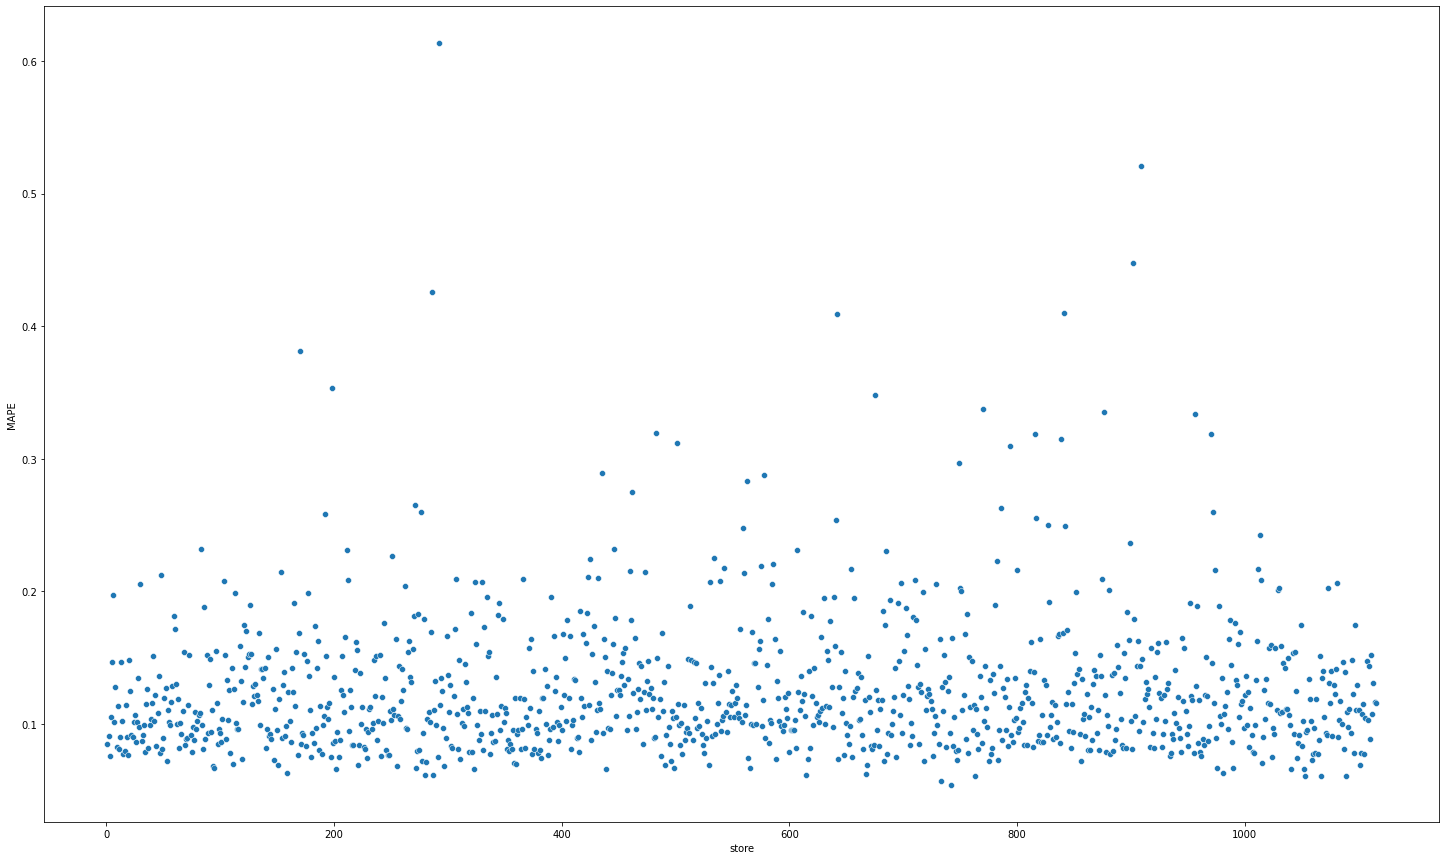

In [81]:
plt.figure(figsize=(25,15))
sns.scatterplot(df92['store'], df92['MAPE'])

## 9.2 Total Performance

In [82]:
df93 = df92[['predictions', 'worst_scenarios', 'best_scenarios']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$281,414,656.00"
1,worst_scenarios,"R$280,466,871.28"
2,best_scenarios,"R$281,414,814.23"


## 9.3 Machine Learning Performance

In [83]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

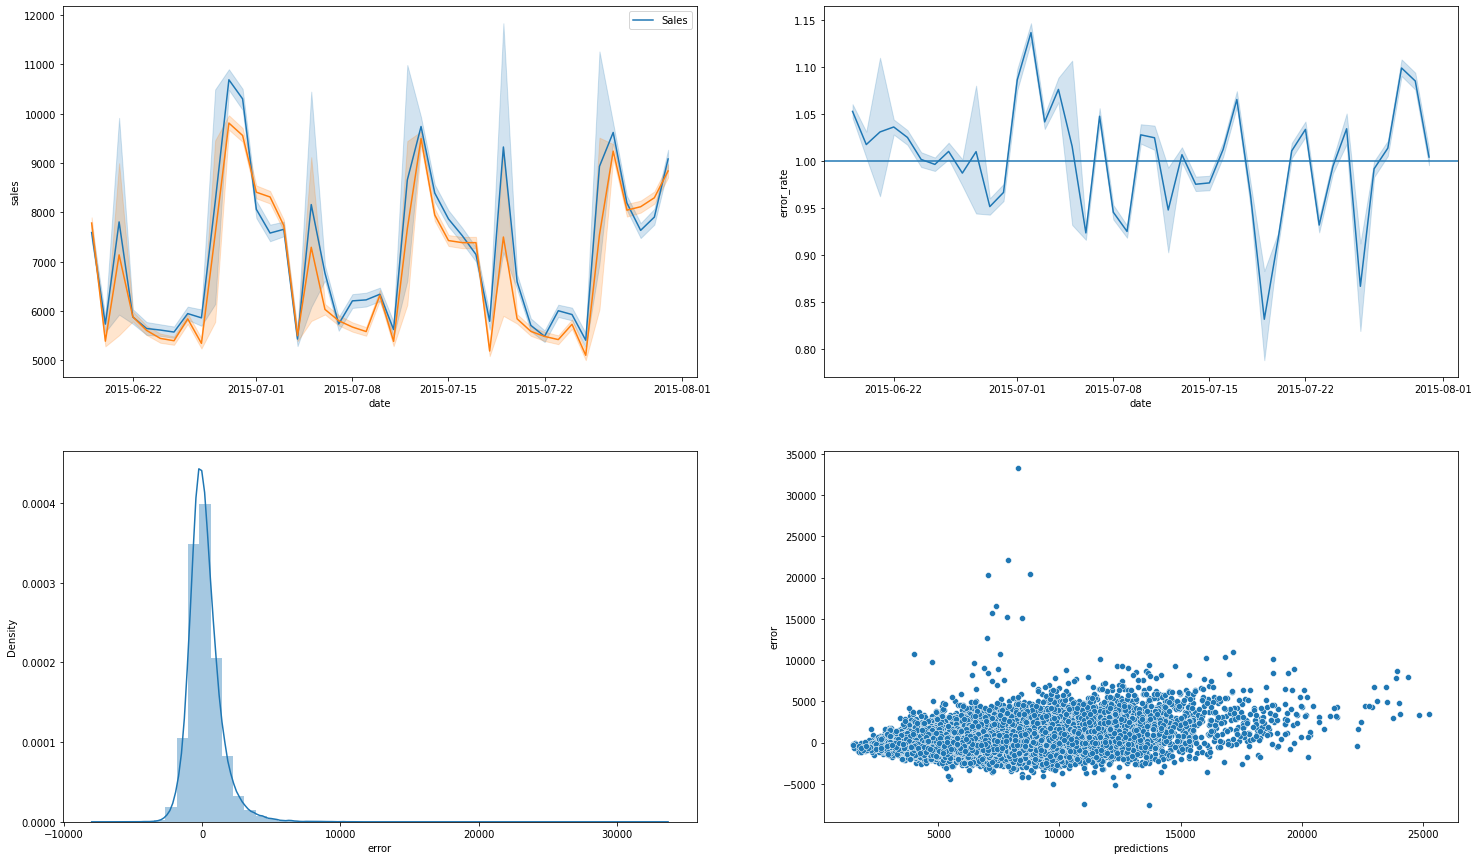

In [84]:
plt.figure(figsize=(25,15))
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales')
sns.lineplot(x='date', y='predictions', data=df9)

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='-')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df9)


# 10. DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [85]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime as dt

class Rossmann(object):
       def __init__(self):
              self.home_path = ''
              self.competition_distance_scaler =        pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb'))
              self.competition_time_month_scaler =      pickle.load(open(self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb'))
              self.promo_time_week_scaler =             pickle.load(open(self.home_path + 'parameters/promo_time_week_scaler.pkl', 'rb'))
              self.competition_time_month_scaler =      pickle.load(open(self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb'))
              self.competition_distance_scaler =        pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb'))
              self.year_scaler =                        pickle.load(open(self.home_path + 'parameters/year_scaler.pkl', 'rb'))
              self.store_type_scaler =                  pickle.load(open(self.home_path + 'parameters/store_type_scaler.pkl', 'rb'))


       def data_cleanning(self, df1):
     
              cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                            'CompetitionDistance', 'CompetitionOpenSinceMonth',
                            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                            'Promo2SinceYear', 'PromoInterval']

              snakecase = lambda x: inflection.underscore( x )
              cols_new = list(map(snakecase, cols_old))

              df1.columns = cols_new
              df1['date'] = pd.to_datetime(df1['date'])
              df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
              df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
              df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
              df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
              df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
              month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dez'}
              df1['promo_interval'].fillna(0, inplace=True)
              df1['month_map'] = df1['date'].dt.month.map(month_map)
              df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
              df1['competition_open_since_month'] = np.int64(df1['competition_open_since_month'])
              df1['competition_open_since_year'] = np.int64(df1['competition_open_since_year'])
              df1['promo2_since_week'] = np.int64(df1['promo2_since_week'])
              df1['promo2_since_year'] = np.int64(df1['promo2_since_year'])
              return df1
              

       def feature_engeniering(self, df2):

              df2['year'] = df2['date'].dt.year
              df2['month'] = df2['date'].dt.month
              df2['day'] = df2 ['date'].dt.day
              df2['week_of_year'] = df2['date'].dt.isocalendar().week
              df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')
              df2['competition_since'] = df2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
              df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
              df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
              df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(x + '-1', '%Y-%W-%w') - dt.timedelta(days=7))
              df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(int)
              df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
              df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else  'christmas' if x == 'c' else 'regular_day')
              df2 = df2[(df2['open'] != 0)]
              cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
              df2 = df2.drop(cols_drop, axis=1)
              return df2


       def data_preparation(self, df5):

              df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
              df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
              df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
              df5['year'] = self.year_scaler.transform(df5[['year']].values)
              df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
              df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])
              assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
              df5['assortment'] = df5['assortment'].map(assortment_dict)
              df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
              df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))
              df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
              df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
              df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
              df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
              df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
              df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))
              cols_selected = ['store', 'promo','store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 
                               'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 
                               'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
              
              return df5[cols_selected]

       def get_prediction( self, model, original_data, test_data ):
             pred = model.predict( test_data )
             original_data['prediction'] = np.expm1( pred )
             
             return original_data.to_json( orient='records', date_format='iso' )
              

              

## 10.2 API Handler

In [86]:
#import pickle
#import pandas as pd
#from flask             import Flask, request, Response


#model = pickle.load(open('model/model_rossman.pkl', 'rb'))

#app = Flask(__name__)

#@app.route('/rossmann/predict', methods=['POST'])
#def rossmann_predict():
#    test_json = request.get_json()
#   
#    if test_json: # there is data
#        if isinstance(test_json, dict): # unique example
#            test_raw = pd.DataFrame(test_json, index=[0])
            
#        else: # multiple example
#            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
#            
#        # Instantiate Rossmann class
#        pipeline = Rossmann()
#        
#        # data cleaning
#        df1 = pipeline.data_cleaning(test_raw)
       
        # feature engineering
#        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
#        df3 = pipeline.data_preparation(df2)
        
        # prediction
#        df_response = pipeline.get_prediction(model, test_raw, df3)
        
#        return df_response
        
        
#    else:
#        return Response( '{}', status=200, mimetype='application/json' )

#if __name__ == '__main__':
#    app.run()

## 10.3 API Tester

In [87]:
df10 = pd.read_csv('data/test.csv')

In [88]:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

df_test = df_test[df_test['Store'].isin([12, 21, 19])]
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [89]:
import json
data = json.dumps(df_test.to_dict(orient='records'))

In [90]:
import requests
#url = 'http://127.0.0.1:8080/rossmann/predict'
url = 'https://pred-rosman-sales.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
r.status_code

200

In [91]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [92]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print('Loja Número: {} Vai vender: {:,.2f} '.format(d2.loc[i, 'store'], 
                                                        d2.loc[i, 'prediction']))

Loja Número: 12 Vai vender: 297,335.40 
Loja Número: 19 Vai vender: 262,796.03 
Loja Número: 21 Vai vender: 236,174.91 
